# Data challenge 1

In this challenge 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [100]:
employee_retention = pd.read_csv('employee_retention_data.csv')

In [102]:
employee_retention['join_date_num'] = pd.to_datetime(employee_retention['join_date'])
employee_retention['quit_date_num'] = pd.to_datetime(employee_retention['quit_date'])

In [104]:
employee_retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_num,quit_date_num
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011-10-17,2014-08-22


In [164]:
employee_retention.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [71]:
max_date = employee_retention.loc[:,['join_date_num','quit_date_num']].max().max()
min_date = employee_retention.loc[:,['join_date_num','quit_date_num']].min().min()
employee_date_range = pd.date_range(start=min_date,end=max_date)

In [150]:
companies=employee_retention['company_id'].unique()

In [116]:
#Head count function
def headcount(df,daterange = employee_date_range ):
    
    #iterate through date ranges
    #ask how many are less than or equal to that value
    join_to_date = pd.Series([
        df.loc[df['join_date_num']<=datetup].shape[0] for 
        datetup in daterange])
    
    quit_to_date = pd.Series([
        df.loc[df['quit_date_num']<=datetup].shape[0] for 
        datetup in daterange])
    
    #head count 
    hc = join_to_date - quit_to_date
    
    df_out = pd.DataFrame()
    df_out['day'] = daterange
    df_out['headcount'] = hc
    
    return(df_out)


In [118]:
headcount_by_company = employee_retention.groupby('company_id').apply(headcount)

In [160]:
headcount_by_company.head()

day  headcount
company_id                        
1          0 2011-01-24         25
           1 2011-01-25         27
           2 2011-01-26         29
           3 2011-01-27         29
           4 2011-01-28         29

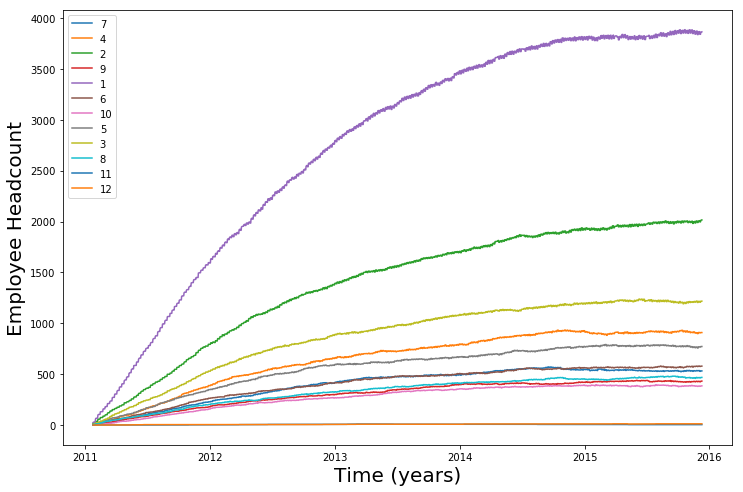

In [163]:
fig, ax = plt.subplots(figsize=(12,8))
for company in companies:
    df = headcount_by_company.loc[company]
    plt.plot(df['day'],df['headcount'],label=company)
plt.legend()   
ax.set_ylabel('Employee Headcount',fontsize=20)
ax.set_xlabel('Time (years)',fontsize=20)


## Analysis

In [182]:
employee_retention['tenure_to_date'] = pd.Series([min(pd.to_datetime('2015-12-13'),i) for 
                                           i in employee_retention['quit_date_num']]) - employee_retention['join_date_num']
    
employee_retention['tenure_to_quit'] = employee_retention['quit_date_num'] - employee_retention['join_date_num']
    


In [185]:
employee_retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_num,quit_date_num,tenure,tenure_to_date,tenure_to_quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014-03-24,2015-10-30,585 days,585 days,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013-04-29,2014-04-04,340 days,340 days,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,2014-10-13,NaT,426 days,426 days,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012-05-14,2013-06-07,389 days,389 days,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011-10-17,2014-08-22,1040 days,1040 days,1040 days


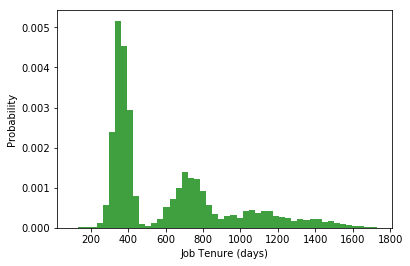

In [197]:
n, bins, patches = plt.hist((employee_retention['tenure_to_quit'].dropna()/pd.Timedelta(days=1)), 50, normed=1, facecolor='g', alpha=0.75)

plt.xlabel('Job Tenure (days)')
plt.ylabel('Probability')
plt.show()

It appears that there are a couple modes of time when people quit. The largest peak is around 1 year (365 day) mark, then there is another peak around 2 year and maybe some uptick around 3. It seems that there is something to leaving around 1 year.

# Model

For my first model I have chosen to focus on what determines whether an employee will leave during the first 18 months of tenure or not. This question was motivated by the observation of a large peak of leavers around the 1 year mark. My hypothesis is that this group of people have particular reasons for leaving so quickly.

To build the model, here is what I need:
* Encode leave after 18 months as 0/1 value
* Build Tenure/salary ratio as an additional feature
    

In [273]:
def leftbefore(df,tenure):
    lowtenure = employee_retention['tenure_to_date'] <= pd.Timedelta(days=tenure)
    hasquit = employee_retention['tenure_to_quit'] > pd.Timedelta(days=1)
    leftearly = []
    for i in range(len(lowtenure)):
        if lowtenure[i] and hasquit[i]:
            leftearly.append(1)
        elif not lowtenure[i]:
            leftearly.append(0)
        else:
            leftearly.append(np.nan)
    df['leftearly'] = pd.Series(leftearly)
    

In [274]:
leftbefore(employee_retention,540)

In [353]:
employee_retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_num,quit_date_num,tenure,tenure_to_date,tenure_to_quit,leftearly
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014-03-24,2015-10-30,585 days,585 days,585 days,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013-04-29,2014-04-04,340 days,340 days,340 days,1.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,2014-10-13,NaT,426 days,426 days,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012-05-14,2013-06-07,389 days,389 days,389 days,1.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011-10-17,2014-08-22,1040 days,1040 days,1040 days,0.0


In [360]:
employee_retention['join_month'] = pd.Series([int(i.month) for i in employee_retention['join_date_num']])

In [361]:
model_mat = employee_retention.dropna(axis=0,subset=['leftearly']).loc[:,
    ['leftearly','company_id','dept','seniority','salary','join_month']]

In [363]:
model_mat.head()

,leftearly,company_id,dept,seniority,salary,join_month
0,0.0,7,customer_service,28,89000.0,3
1,1.0,7,marketing,20,183000.0,4
3,1.0,7,customer_service,20,115000.0,5
4,0.0,2,data_science,23,276000.0,10
5,0.0,4,data_science,14,165000.0,1


In [348]:
def seniorityratio(df):
    z_sal = (df['salary'] - df['salary'].mean())/(df['salary'].std())
    z_sen = (df['seniority'] - df['seniority'].mean())/(df['seniority'].std())
    sen_rat = z_sal/z_sen
    return(sen_rat)

In [364]:
model_mat['seniority_ratio'] = model_mat['salary']/model_mat['seniority'] #pd.Series(np.hstack(model_mat.groupby('company_id').apply(seniorityratio)))

In [482]:
model_mat.head()

,leftearly,company_id,dept,seniority,salary,join_month,seniority_ratio
0,0.0,7,customer_service,28,89000.0,3,3178.571429
1,1.0,7,marketing,20,183000.0,4,9150.000000
3,1.0,7,customer_service,20,115000.0,5,5750.000000
4,0.0,2,data_science,23,276000.0,10,12000.000000
5,0.0,4,data_science,14,165000.0,1,11785.714286


In [477]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [395]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

company_integer = label_encoder.fit_transform(model_mat['company_id'])
company_integer = company_integer.reshape(len(company_integer), 1)
company_onehot= pd.DataFrame(onehot_encoder.fit_transform(company_integer))
company_onehot.columns = ['company_'+str(i+1) for i in range(12)]

In [405]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

dept_integer = label_encoder.fit_transform(model_mat['dept'])
dept_integer = dept_integer.reshape(len(dept_integer), 1)
dept_onehot= pd.DataFrame(onehot_encoder.fit_transform(dept_integer))
dept_onehot.columns = [i for i in label_encoder.classes_]

In [410]:
company_onehot.shape

(18215, 12)

In [411]:
dept_onehot.shape

(18215, 6)

In [429]:
model_mat.loc[:,
    ['leftearly','seniority','salary','join_month']].head()

,leftearly,seniority,salary,join_month
0,0.0,28,89000.0,3
1,1.0,20,183000.0,4
3,1.0,20,115000.0,5
4,0.0,23,276000.0,10
5,0.0,14,165000.0,1


In [434]:
company_dept_hot = pd.concat([company_onehot,dept_onehot],axis=1)

In [456]:
company_dept_hot.head()

,company_1,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,company_10,company_11,company_12,customer_service,data_science,design,engineer,marketing,sales
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [483]:
model_mat_hot = pd.concat([model_mat.reset_index().loc[:,
    ['leftearly','seniority','salary','join_month','seniority_ratio']],company_dept_hot],axis=1)

In [486]:
 model_mat_hot.iloc[:,1:5].describe()

,seniority,salary,join_month,seniority_ratio
count,18215.000000,18215.000000,18215.000000,18215.000000
mean,14.148614,138202.525391,6.274060,12864.518467
std,8.076011,75478.647558,3.415596,9706.209147
min,1.000000,17000.000000,1.000000,1868.686869
25%,7.000000,79000.000000,3.000000,6777.777778
50%,14.000000,123000.000000,6.000000,10368.421053
75%,21.000000,187000.000000,9.000000,15341.666667
max,99.000000,408000.000000,12.000000,93000.000000


In [487]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    model_mat_hot.iloc[:,1:5],
    model_mat_hot.iloc[:,0],test_size=0.25,random_state=101)

clf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [5, 10, 15, 20],
                 'max_depth': [2, 5, 7, 9]
             }



In [488]:
full_rand_forest = GridSearchCV(clf, param_grid, cv=10).fit(X_train,y_train)


In [489]:
full_logistic_regression = LogisticRegression().fit(X_train,y_train)

In [497]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [498]:
from sklearn.metrics import confusion_matrix
import itertools
y_hat_rf = full_rand_forest.predict(X_test)
y_hat_lr = full_logistic_regression.predict(X_test)
rf_cm = confusion_matrix(y_test, y_hat_rf)
lr_cm = confusion_matrix(y_test, y_hat_lr)



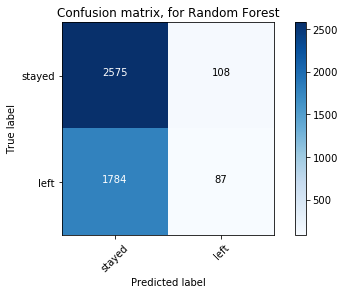

In [499]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(rf_cm, classes=['stayed','left'],
                      title='Confusion matrix, for Random Forest')

plt.show()

# Discussion

Overall neither the random forest or logisitc regression model are working well as I have them now. Although the random forest is doing ever so slightly better, both are worse than flipping a coin. My idea to predict whether a person will leave before 18 months may not have been a good one.

If I could have an additional piece of information I would want to see the employees most recent performance review scores.